# Rejection ABC


PINTS can be used to perform inference for stochastic forward models. Here, we perform inference on the [stochastic degradation model](../toy/model-stochastic-degradation.ipynb) using Approximate Bayesian Computation (ABC). This model has only a single unknown parameter -- the rate at which chemicals degrade. We use the "rejection ABC" method to estimate this unknown and provide a measure of uncertainty in it.

First, we load the stochastic degradation model and perform 10 simulations from it. The variation inbetween runs is due to the inherent stochasticity of this type of model.

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

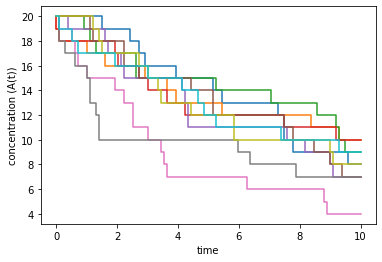

In [2]:
np.random.seed(3)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using Rejection ABC

The rejection ABC method can be used to perform parameter inference for stochastic models, where the likelihood is intractable. In ABC methods, typically, a distance metric comparing the observed data and the simulated is used. Here, we use the root mean square error (RMSE), and we accept a parameter value if the $RMSE<1$.

In [3]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     198    0.00505050505    0:00.2
2     213    0.00938967136    0:00.2
3     271    0.0110701107     0:00.2
20    1081   0.0185013876     0:00.8
40    2389   0.0167434073     0:01.8
60    3734   0.0160685592     0:02.8
80    4774   0.0167574361     0:03.5
100   6078   0.0164527805     0:04.5
120   7352   0.0163220892     0:05.4
140   8780   0.0159453303     0:06.5
160   10169  0.0157340938     0:07.5
180   11237  0.0160185103     0:08.3
200   12453  0.0160603871     0:09.2
220   14073  0.015632772      0:10.4
240   15457  0.0155269457     0:11.4
260   16782  0.0154927899     0:12.4
280   18094  0.015474743      0:13.4
300   19290  0.0155520995     0:14.3
320   20742  0.0154276348     0:15.4
340   21715  0.0156573797     0:16.1
360   23213  0.0155085512     0:17.2
380   24642  0.0154208262     0:18.2
400   25951  0.0154136642     0:19.2
420   27092  0.0155027314     0:20.0
440   28605  0.0

We now plot the ABC posterior samples versus the actual value that was used to generate the data. This shows that, in this case, the parameter could be identified given the data.

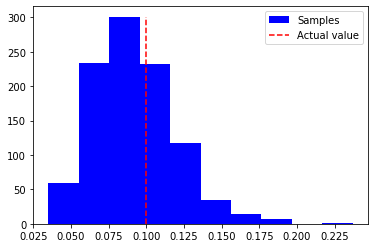

In [4]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
plt.legend()
plt.show()